# SUICIDAL IDEATION DETECTION

## 1.0 Problem statement & motivation

Mental health issues like depression are increasing globally, especially among the youth. Many individuals share symptoms or feelings in anonymous online forums before seeking help. This project will use Natural Language Processing (NLP) on Reddit posts to identify potential signs of
depression, allowing for early intervention and improved healthcare response.

## 1.1 Stakeholders

- Mental health professionals
- NGOs focused on mental health
- Public health policymakers 
- Digital mental health platforms.

## 1.2 Ethical Considerations

### - Privacy and Consent

Reddit posts are publicly accessible, but users may not expect them to be used for mental health analysis.

No personally identifiable information (PII), usernames, or post IDs are stored or referenced.

Data is anonymized and handled in strict compliance with [Reddit Terms of Service](https://www.redditinc.com/policies/data-api-terms)

### - Psychological Safety
The model is designed for academic exploration and public health awareness—not for clinical decision-making.

No automatic interventions are triggered based on model predictions.

Results are interpreted with caution to avoid misclassifying vulnerable individuals.
### - Bias and Fairness
NLP models may underrepresent or misinterpret signals from marginalized communities.

Fairness metrics and feature attribution techniques (e.g SHAP) are employed to ensure model decisions aren’t driven by irrelevant demographic indicators.

Continuous auditing for linguistic bias is recommended.
### - Transparency and Interpretability
The full model pipeline—from preprocessing to predictions—is documented.

### - Human Oversight

This tool is not a diagnostic system; human judgment remains central.

Suggestions for high-risk content are intended to augment, not replace, mental health professionals.

### - Use and Dissemination

The notebook is published with disclaimers clarifying its scope: research and educational use only.

Any downstream applications must be evaluated through an ethical review process.

Collaboration with mental health experts and community moderators is encouraged for real-world impact.


## 1.3 Project objectives


- Use NLP to classify Reddit posts as depression-related or not

- Apply interpretable models to understand which words/phrases contribute to depression
predictions.

- Evaluate model performance using precision, recall, F1-score, and ROC-AUC, with stratified validation to handle potential class imbalance.

- Provide recommendations for how health organizations can use the model for early warning system

## 2. Data Understanding

In [3]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import itertools
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore")




[nltk_data] Downloading package punkt to C:\Users\ngati/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ngati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\ngati/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# loading data into dataframe

df = pd.read_csv('Suicide_Detection.csv')
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [5]:
# shape of df

df.shape

(232074, 3)

In [6]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


In [7]:
#show distribution of the target variable
df['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [8]:
# count of each class 
df['class'].value_counts()

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64

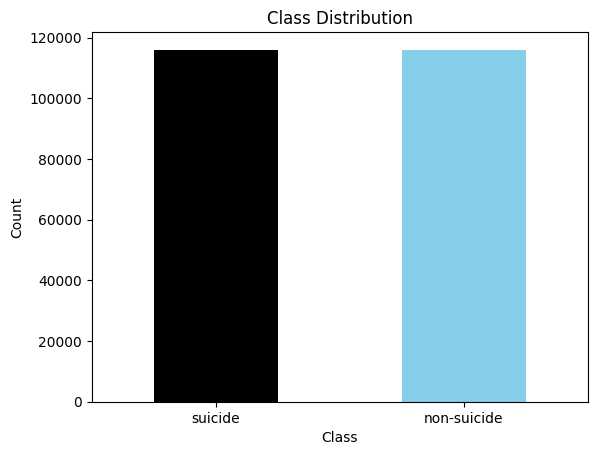

In [9]:
# Class Distribution(Suicidal vs non-suicidal)
df['class'].value_counts().plot(kind='bar', color=['black', 'skyblue'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Dataset used was sourced from kaggle, which was then loaded into a pandas dataframe. The dataset contains 232,074 entries and 3 columns. The columns include text , the reddit post content, and class which is the target variable that is either 'suicide' or 'non-suicide'. The dataset is perfectly balanced with 116, 037 entries for both 'suicide' and 'non-suicide' classes. This will prevent the model from being biased towards the mojority class.

### 3. DATA PRE-PROCESSING
This step prepares the raw text data for modeling. We'll clean the text, tokenize it, remove stopwords, lemmatize the tokens, and convert the text into numerical features using TF-IDF.


In [10]:
#Drop the unnecessary index column
df.drop(columns=["Unnamed: 0"], inplace=True)

In [11]:
#Remove duplicates
df.drop_duplicates(subset='text', inplace=True)

In [12]:
# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ngati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Lowercasing the text column and removing punctuations, numbers,and other characters
# what the code should do is lowercase, expand contractions e.g can't to can not, keep apostrophes during cleaning
#Removes all other punctuations, remove stopwords, filter out short or empty texts
def clean_text(text):
    text = text.lower()

    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'m", " am", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'d", " would", text)

    text = re.sub(r"[^\w\s']", "", text)#keeps apostrophes
    text = re.sub(r"\s+", " ", text).strip()

   
    return ' '.join([word for word in text.split() if word not in stop_words])
# apply the cleaning
df['clean_text'] = df['text'].apply(clean_text)

#filter out empty rows
df = df[df['clean_text'].str.strip().str.len() > 0]
 

In [14]:
#tokenization
df['tokens'] = df['clean_text'].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])

In [15]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [16]:
# Encode target labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['class'])

## Exploratory Text Analysis

We explore word frequencies, word clouds, and emotional keyword patterns to better understand how suicidal and non-suicidal posts differ.


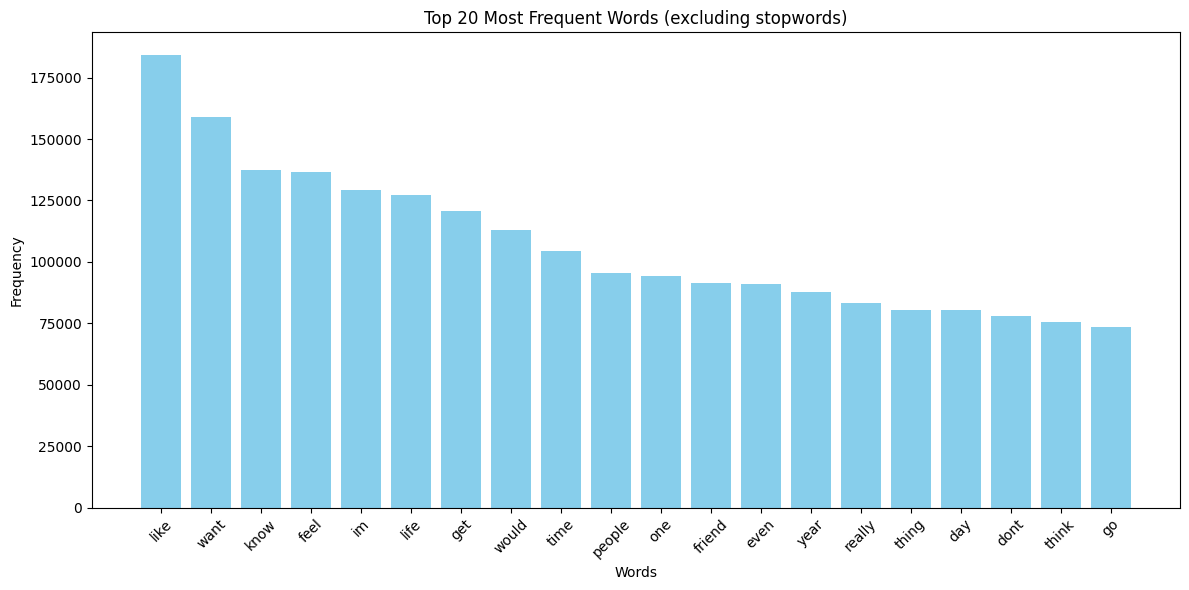

In [17]:
# Flatten token list and count word frequencies
filtered_tokens = [word for tokens in df['tokens'] for word in tokens]# Count word frequency
word_counts = Counter(filtered_tokens)
top_words = word_counts.most_common(50)

# Bar chart of top 20
words, counts = zip(*top_words[:20])
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words (excluding stopwords)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

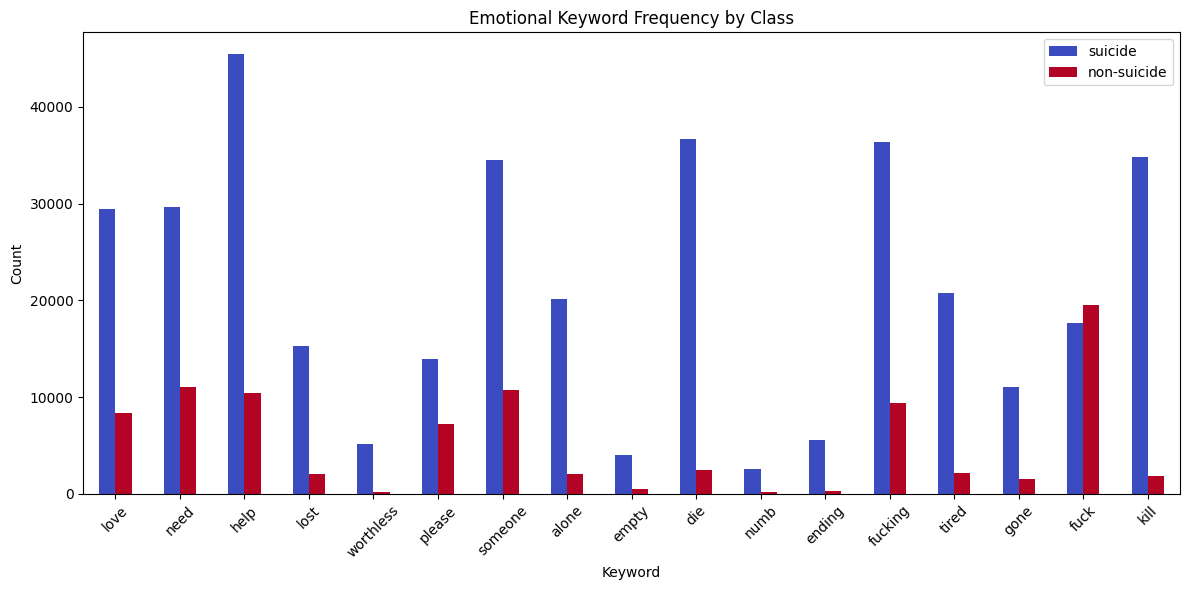

In [18]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# Define emotionally charged keywords commonly found in suicidal ideation
emotional_keywords = {
    'alone', 'tired', 'lost', 'worthless', 'help', 'please', 'die',
    'kill', 'empty', 'numb', 'ending', 'gone', 'love', 'need',
    'fuck', 'fucking', 'someone'
}

# Function to count how many emotional keywords appear in a group of posts
def count_emotional_keywords(posts):
    all_text = ' '.join(posts['clean_text'])  # merge all posts
    tokens = all_text.split()
    counts = Counter([word for word in tokens if word in emotional_keywords])
    return counts

# Separate suicidal and non-suicidal posts
suicide_posts = df[df['label'] == 1]     # Suicidal
nonsuicide_posts = df[df['label'] == 0]  # Non-suicidal

# Count emotional keyword occurrences in both groups
suicide_counts = count_emotional_keywords(suicide_posts)
nonsuicide_counts = count_emotional_keywords(nonsuicide_posts)

# Combine into a DataFrame for comparison
emotion_df = pd.DataFrame([suicide_counts, nonsuicide_counts], index=['suicide', 'non-suicide']).T.fillna(0)

# Plot comparison
emotion_df[['suicide', 'non-suicide']].plot(kind='bar', figsize=(12, 6), colormap='coolwarm')
plt.title("Emotional Keyword Frequency by Class")
plt.xlabel("Keyword")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### 4. MODELING

We'll build predictive models using a pipeline approach. This ensures text preprocessing (TF-IDF) and modeling are performed seamlessly. We will use:
- Logistic Regression (for interpretability)
- Support Vector Machine (for performance)

Evaluation metrics include Accuracy, F1-Score, Confusion Matrix, and ROC AUC.

### Logistic Regression

In [19]:
df['text'] = df['clean_text'].astype(str).str.slice(0, 500)

# Add character and word counts
df['char_count'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

# Add sentiment scores
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

df['sentiment'] = df['text'].apply(lambda x: sid.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ngati/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [20]:
from sklearn.model_selection import train_test_split

# Features and labels
X = df['clean_text']  # use cleaned and lemmatized text
y = df['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [21]:
#TF - IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# Dimensionality Reduction
svd = TruncatedSVD(n_components=100, random_state=42)
X_train_vec_reduced = svd.fit_transform(X_train_vec)
X_test_vec_reduced = svd.transform(X_test_vec)

# Meta Features
meta_cols = ['char_count', 'word_count', 'sentiment']
meta_train = df.loc[X_train.index, meta_cols].reset_index(drop=True).to_numpy()
meta_test = df.loc[X_test.index, meta_cols].reset_index(drop=True).to_numpy()

# Combine Text + Meta Features
X_train_combined = np.hstack([X_train_vec_reduced, meta_train])
X_test_combined = np.hstack([X_test_vec_reduced, meta_test])


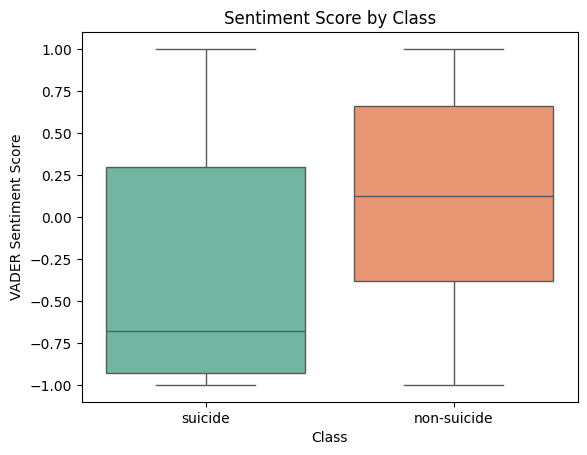

In [22]:
# Visualizations for sentiment vs Class
sns.boxplot(x='class', y='sentiment', data=df, palette='Set2')
plt.title("Sentiment Score by Class")
plt.xlabel("Class")
plt.ylabel("VADER Sentiment Score")
plt.show()

Suicide cases will have a lower VADER(Valence Aware Dictionary and sEntiment) score tending to move towards -1 which shows there is a probability the text is negative

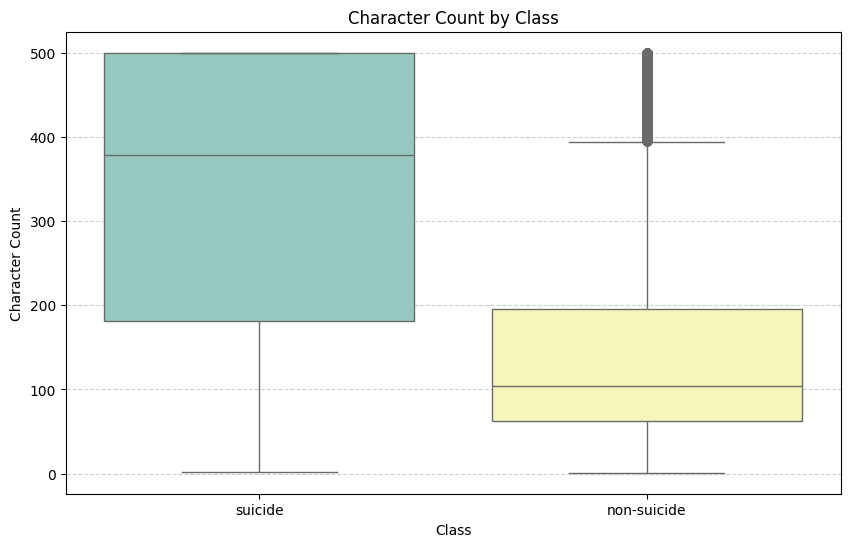

In [23]:
# Visualization of Character count distribution by class

plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='char_count', data=df, palette='Set3')
plt.title("Character Count by Class")
plt.xlabel("Class")
plt.ylabel("Character Count")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

Suicide related posts will tend to have longer characters(longer post length).

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Logistic Regression Parameters: {'clf__C': 10, 'tfidf__max_features': 5000}
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     34804
           1       0.94      0.92      0.93     34809

    accuracy                           0.93     69613
   macro avg       0.93      0.93      0.93     69613
weighted avg       0.93      0.93      0.93     69613



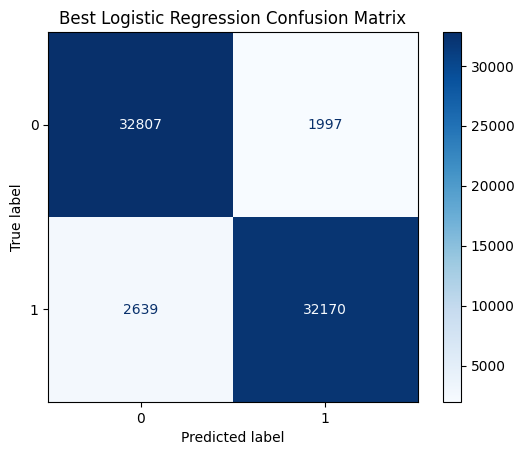

In [24]:

# Logistic Regression pipeline
logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

# Define grid
logreg_params = {
    'tfidf__max_features': [3000, 5000],
    'clf__C': [0.1, 1, 10]
}

# GridSearch
logreg_grid = GridSearchCV(logreg_pipeline, logreg_params, cv=3, scoring='f1', verbose=1, n_jobs=-1)
logreg_grid.fit(X_train, y_train)

# Best model
best_logreg = logreg_grid.best_estimator_
print("Best Logistic Regression Parameters:", logreg_grid.best_params_)

# Evaluation
y_pred = best_logreg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(best_logreg, X_test, y_test, cmap='Blues')
plt.title("Best Logistic Regression Confusion Matrix")
plt.show()



### 5. Optimization 


##### 5.0 SVM(Support Vector Machine)

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

# Define SVM pipeline
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

# Define hyperparameter grid
svm_params = {
    'tfidf__max_features': [3000, 5000],
    'clf__C': [0.1, 1, 10]
}

# Run GridSearchCV
svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=3, scoring='f1', verbose=1, n_jobs=-1)
svm_grid.fit(X_train, y_train)

# Get the best model
best_svm = svm_grid.best_estimator_

print("Best SVM Parameters:", svm_grid.best_params_)



Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best SVM Parameters: {'clf__C': 0.1, 'tfidf__max_features': 5000}


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     34804
           1       0.94      0.92      0.93     34809

    accuracy                           0.93     69613
   macro avg       0.93      0.93      0.93     69613
weighted avg       0.93      0.93      0.93     69613



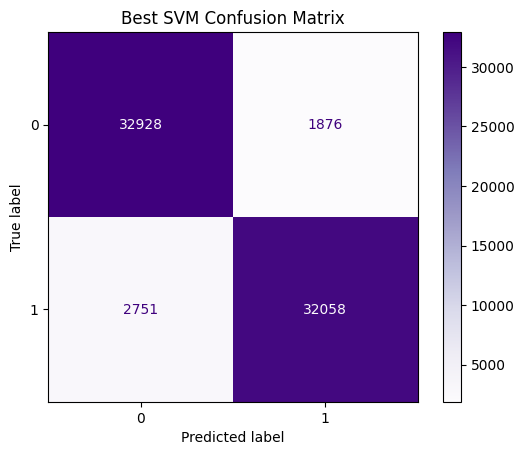

In [26]:
# Evaluation
y_pred_svm = best_svm.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
ConfusionMatrixDisplay.from_estimator(best_svm, X_test, y_test, cmap='Purples')
plt.title("Best SVM Confusion Matrix")
plt.show()

#### 5.1 Random Forest


#### Evaluation

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Collect metrics for Logistic Regression
y_pred_logreg = best_logreg.predict(X_test)
logreg_proba = best_logreg.predict_proba(X_test)[:, 1]

logreg_metrics = {
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred_logreg),
    'Precision': precision_score(y_test, y_pred_logreg),
    'Recall': recall_score(y_test, y_pred_logreg),
    'F1 Score': f1_score(y_test, y_pred_logreg),
    'AUC': roc_auc_score(y_test, logreg_proba)
}

# Collect metrics for SVM
y_pred_svm = best_svm.predict(X_test)
svm_metrics = {
    'Model': 'SVM (Linear)',
    'Accuracy': accuracy_score(y_test, y_pred_svm),
    'Precision': precision_score(y_test, y_pred_svm),
    'Recall': recall_score(y_test, y_pred_svm),
    'F1 Score': f1_score(y_test, y_pred_svm),
    'AUC': 'N/A'  # SVM doesn't provide probabilities by default
}

# Combine into a DataFrame
results_df = pd.DataFrame([logreg_metrics, svm_metrics])
results_df.set_index('Model', inplace=True)
results_df


,Accuracy,Precision,Recall,F1 Score,AUC
Model,,,,,
Logistic Regression,0.933403,0.941552,0.924186,0.932788,0.980929
SVM (Linear),0.933533,0.944716,0.920969,0.932691,N/A


## Neural Network Model (Keras)

We implement a deep learning model using Keras. This model will use embeddings and dense layers to classify suicidal ideation from Reddit posts.


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


# Tokenize the text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Pad sequences to uniform length
X_nn = pad_sequences(sequences, maxlen=200)
y_nn = df['label'].values

# Train-test split
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42, stratify=y_nn)


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout

# Build the model
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=200),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_nn, y_train_nn, validation_split=0.2, epochs=5, batch_size=64)


In [ ]:


# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:


# Predict and evaluate
y_pred_nn = (model.predict(X_test_nn) > 0.5).astype("int32")
print(classification_report(y_test_nn, y_pred_nn))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_nn, y_pred_nn, cmap='Blues')
plt.title("Neural Network Confusion Matrix")
plt.show()


### Evaluation summary for the 3 models

In [ ]:

# Flatten prediction array
y_pred_nn_flat = y_pred_nn.flatten()

# Compute metrics for Neural Network
nn_metrics = {
    'Model': 'Neural Network',
    'Accuracy': accuracy_score(y_test_nn, y_pred_nn_flat),
    'Precision': precision_score(y_test_nn, y_pred_nn_flat),
    'Recall': recall_score(y_test_nn, y_pred_nn_flat),
    'F1 Score': f1_score(y_test_nn, y_pred_nn_flat),
    'AUC': roc_auc_score(y_test_nn, y_pred_nn_flat)}



results_df = pd.DataFrame([logreg_metrics, svm_metrics, nn_metrics])
results_df.set_index('Model', inplace=True)
results_df

### TUNING NEURAL NETWORKS WITH LTSM

We use LTSM because
1. Sequential understanding	LSTMs learn word order and context across a sentence (important for meaning).
2. Long-range dependency - LSTMs are good at remembering things like: “I don’t want to live” even if the words are far apart.
3. Emotion-rich text- Suicidal posts often use phrases where sequence matters more than word presence (e.g., “I’m tired of living” ≠ “Living makes me tired”).

In [ ]:
# Defining a build function for LTSM

def build_model(optimizer='adam'):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=64, input_length=200),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from scikeras.wrappers import KerasClassifier

#wrap it in kerasclassifier
clf = KerasClassifier(
    model=build_model,
    optimizer='adam', 
    epochs=3,
    batch_size=32,
    verbose=0)

#set up hyperparameter grid
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [3],  
    'batch_size': [32, 64]}

#perform GridSearchCV
grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=2, scoring='accuracy', verbose=2, n_jobs=-1)
grid_result = grid.fit(X_train_nn, y_train_nn)

#Evaluate the best model
best_keras = grid_result.best_estimator_
print("Best Params:", grid_result.best_params_)

# Predictions
y_pred_keras = (best_keras.predict(X_test_nn) > 0.5).astype("int32")

# Report & Confusion Matrix
print("Keras Classifier Classification Report:")
print(classification_report(y_test_nn, y_pred_keras))

ConfusionMatrixDisplay.from_predictions(y_test_nn, y_pred_keras, cmap='Oranges')
plt.title("KerasClassifier Confusion Matrix")
plt.show()



In [ ]:
#add LTSM to the comparison table
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

lstm_metrics = {
    'Model': 'LSTM (Keras)',
    'Accuracy': accuracy_score(y_test_nn, y_pred_keras),
    'Precision': precision_score(y_test_nn, y_pred_keras),
    'Recall': recall_score(y_test_nn, y_pred_keras),
    'F1 Score': f1_score(y_test_nn, y_pred_keras),
    'AUC': roc_auc_score(y_test_nn, y_pred_keras)
}

results_df = pd.DataFrame([logreg_metrics, svm_metrics, nn_metrics, lstm_metrics])
results_df.set_index('Model', inplace=True)
results_df

In [34]:
!jupyter nbconvert --to script your_notebook_name.ipynb

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'your_notebook_name.ipynb' matched no files


In [35]:
!jupyter nbconvert --to script notebook-checkpoint.ipynb


This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'notebook-checkpoint.ipynb' matched no files


In [36]:
!jupyter nbconvert --to script notebook.ipynb

[NbConvertApp] Converting notebook notebook.ipynb to script
[NbConvertApp] Writing 20417 bytes to notebook.py
